In [1]:
"""
Persist and train!
"""
import os
os.system("pip install pandas-ml")

0

In [2]:
import keras.backend as K
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import \
    preprocess_input as densenet_preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from keras.callbacks import (EarlyStopping, LearningRateScheduler, ReduceLROnPlateau,CSVLogger,
                                        ModelCheckpoint, TensorBoard)
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Input
from keras.models import Model, Sequential, load_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import get_file
from PIL import Image, ImageFile
from sklearn.metrics import (classification_report, cohen_kappa_score,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import class_weight, shuffle

import imblearn

from another_lrfinder import LRFinder

import warnings
warnings.filterwarnings("ignore")

import pandas_ml as pdml
import cv2

import matplotlib.pyplot as plt
plt.style.use('seaborn')

ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.


## Retinopathy dataset

#### Issues
- Imbalanced data => imblearn fix 
- Images must be augumented => generators
- Pretrained imagenet doesn't provide good results
- Most models overfit => lrfinder
- Must figure out a good learning rate => lrfinder

In [3]:
###################################################################################################
# Arguments for setting parameters while running array batch job
###################################################################################################

DEBUG_MODE = False

if DEBUG_MODE:
    print("*"*80)
    print("[INFO]: DEBUG_MODE")
    print("*"*80)

## Model settings

In [4]:
WEIGHTS_PATH = None

### Model tuning

In [5]:
OPTIMISER_NAME = "SGD"

# Set verbosity
VERBOSITY = 1

# Set model configuration
EPOCHS =  2 if DEBUG_MODE else 6

BATCH_SIZE = 32
LEARNING_RATE = 0.0001
DROP_EVERY = 20
DROP_FACTOR = 0.25
MOMENTUM = 0.9
NESTEROV=True
LOSS = "categorical_crossentropy"
METRICS = ["accuracy"]

### Image augumentation parameters

In [6]:
HEIGHT = 256
WIDTH = 256
DEPTH = 3

# Image generator information
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1

### Input and output folders

In [7]:
# Dataset folder information
TRAINING_CSV = "../input/innovation-challenge-2019/training-labels.csv"
DATASET_FOLDER = "../input/innovation-challenge-2019/train/output_combined2"
TESTSET_FOLDER = "../input/innovation-challenge-2019/test/Test"

LOGS_FOLDER = "./logs"
WEIGHTS_FOLDER = "./weights"
REPORTS_FOLDER = "./reports"
os.makedirs(LOGS_FOLDER, exist_ok=True)
os.makedirs(WEIGHTS_FOLDER, exist_ok=True)
os.makedirs(REPORTS_FOLDER, exist_ok=True)

TRAINING_LOGS_FILE = os.path.join(REPORTS_FOLDER, "training_logs.csv")
CLASSIFICATION_REPORT_FILE = os.path.join(REPORTS_FOLDER, "classification_report.txt")
CONFUSION_MATRIX_FILE = os.path.join(REPORTS_FOLDER, "confusion_matrix.txt")
COHEN_KAPPA_SCORE_FILE = os.path.join(REPORTS_FOLDER, "cohen_kappa_metric.txt")

## Tackling Imbalanced dataset problem

### Dataset analysis

In [8]:
##################################################################################################
# Read details from CSV
###################################################################################################

DATASET = pd.read_csv(TRAINING_CSV, dtype=str)
DATASET = DATASET[:BATCH_SIZE*12] if DEBUG_MODE else DATASET

In [9]:
# Use pandas-ml
DATASET_ML = pdml.ModelFrame(DATASET, target="Drscore")
samples = DATASET_ML["Drscore"].value_counts().to_dict()
samples

{'0': 9846, '2': 2300, '1': 1027, '3': 648, '4': 324}

In [10]:
sample_size = DATASET_ML["Drscore"].value_counts().median()
sample_size = int(sample_size)
sample_size

1027

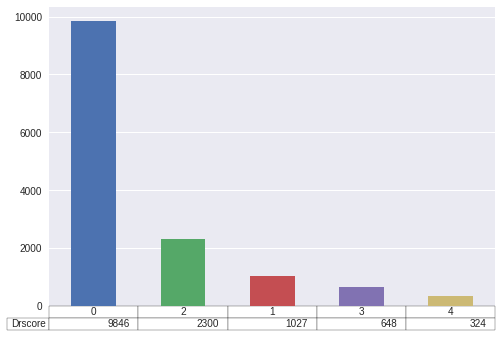

In [11]:
ax = DATASET_ML["Drscore"].value_counts().plot(kind="bar", sort_columns=False, table = True)
ax.get_xaxis().set_visible(False)
ax

### Balancing dataset

#### Oversampling minority classes to reach median sample size

In [12]:
# Oversample values less than sample_size to reach sample_size
over_sampling_strategy = { k: v if v >=sample_size else sample_size for k, v in samples.items() }
over_sampling_strategy

{'0': 9846, '2': 2300, '1': 1027, '3': 1027, '4': 1027}

In [13]:
from imblearn.over_sampling import RandomOverSampler

X = DATASET_ML['Filename'].values.reshape(-1, 1)
y = DATASET_ML['Drscore'].values

X_oversampled, y_oversampled = RandomOverSampler(random_state=42).fit_resample(X, y)

#### Undersampling majority classes to reach median sample size

In [14]:
# under_sampling_strategy = { k: v if v <= sample_size else sample_size for k, v in over_sampling_strategy.items() }
# under_sampling_strategy

In [15]:
# from imblearn.under_sampling import RandomUnderSampler

# X_balanced, y_balanced = RandomUnderSampler( sampling_strategy=under_sampling_strategy, random_state=42).fit_resample(X_oversampled, y_oversampled)

In [16]:
DATASET = pdml.ModelFrame({
    "Filename": X_oversampled.reshape(-1),
    "Drscore": y_oversampled
})

DATASET["Drscore"].value_counts()

1    9846
2    9846
0    9846
4    9846
3    9846
Name: Drscore, dtype: int64

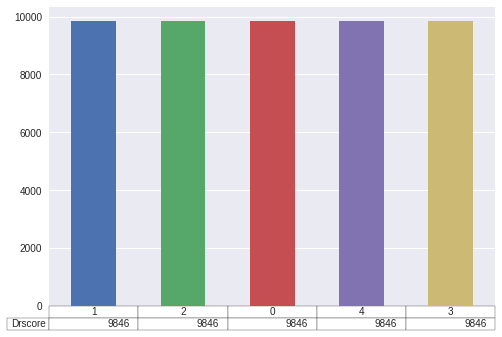

In [17]:
ax = DATASET["Drscore"].value_counts().plot(kind="bar", sort_columns=False, table = True)
ax.get_xaxis().set_visible(False)
ax

#### Visualize dataset

Count : 394


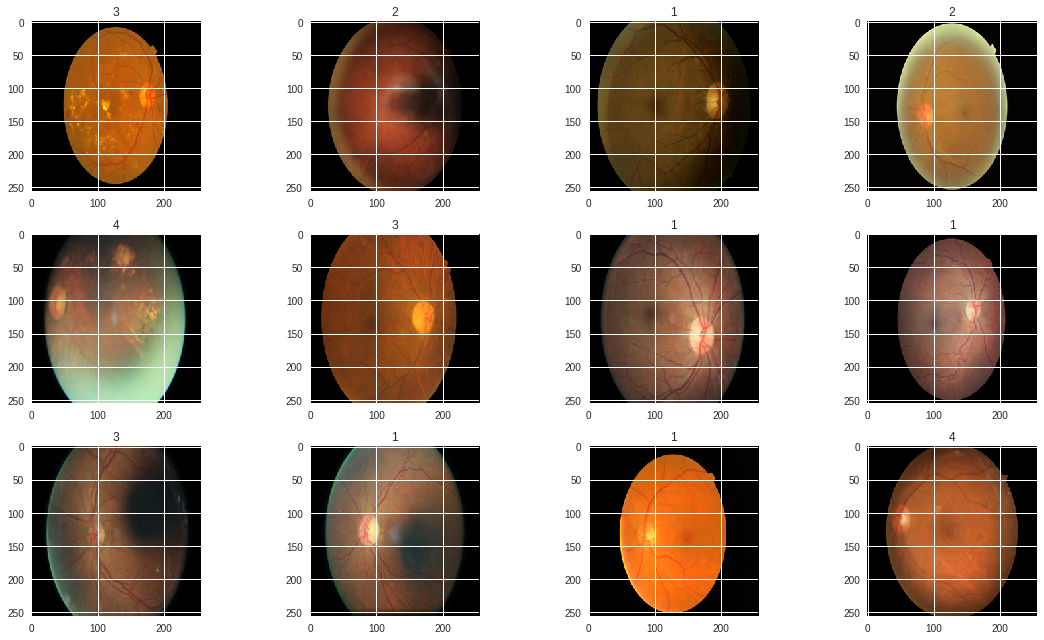

In [18]:
_, df = DATASET.model_selection.train_test_split(test_size=0.008, stratify=DATASET["Drscore"])
df.reset_index(inplace=True)
print(f"Count : {len(df)}" )
df["Drscore"].value_counts()

columns=4
rows=3

fig=plt.figure(figsize=(4*columns, 3*rows))

for i in range(columns*rows):
    image_path = df.loc[i,'Filename']
    image_id = df.loc[i,'Drscore']
    img = Image.open(os.path.join(DATASET_FOLDER, image_path))
    img = img.resize((HEIGHT, WIDTH), Image.ANTIALIAS)
    fig.add_subplot(rows, columns, i+1)
    plt.title(image_id)
    plt.imshow(img)

plt.tight_layout()

### Training, validation and test dataset

In [19]:
TRAIN_VALIDATION, TEST = DATASET.model_selection.train_test_split(test_size=TEST_SPLIT, stratify=DATASET["Drscore"])
TRAIN, VALIDATION = TRAIN_VALIDATION.model_selection.train_test_split(test_size=VALIDATION_SPLIT, stratify=TRAIN_VALIDATION["Drscore"])

In [20]:
TRAIN["Drscore"].value_counts() 

3    7976
4    7975
1    7975
2    7975
0    7975
Name: Drscore, dtype: int64

In [21]:
VALIDATION["Drscore"].value_counts()

2    887
3    886
4    886
1    886
0    886
Name: Drscore, dtype: int64

In [22]:
TEST["Drscore"].value_counts() 

4    985
1    985
0    985
3    984
2    984
Name: Drscore, dtype: int64

### Data augumentation

In [23]:
SHIFT = 20
ROTATION = 10
BRIGHTNESS = [0.2,2.]
SHEAR=2.5
CHANNEL_SHIFT=0.2
ZOOM_RANGE=20.
HORIZONTAL_FLIP = False
VERTICAL_FLIP = False

COLOR_MODE = "grayscale" if DEPTH == 1 else "rgb"

DATAFRAME_ARGS = {
    "directory":DATASET_FOLDER,
    "x_col":"Filename",
    "y_col":"Drscore",
    "class_mode":"categorical",
    "color_mode":COLOR_MODE,
    "target_size":(HEIGHT, WIDTH),
    "batch_size":BATCH_SIZE,
    "drop_duplicates": False
}

#### Data sampling for featurewise mean and centering

In [24]:
# SAMPLE_SPLIT = 0.02
# _, SAMPLE = TRAIN.model_selection.train_test_split(test_size=SAMPLE_SPLIT, stratify=TRAIN["Drscore"])

# def process_sample(image_path):
#     image = Image.open(os.path.join(DATASET_FOLDER, image_path))
#     image = image.resize((HEIGHT, WIDTH),Image.ANTIALIAS)
#     return np.array(image).astype(np.uint16)

# SAMPLE_DATA = np.array([ process_sample(row["Filename"]) for i, row in SAMPLE.iterrows()])
    
# columns=4
# rows=3

# fig=plt.figure(figsize=(4*columns, 3*rows))

# for i in range(columns*rows):
#     fig.add_subplot(rows, columns, i+1)
#     plt.imshow(SAMPLE_DATA[i].astype(np.uint8))
# plt.tight_layout()

####  Create data generator to augment images for training and validation

In [25]:
preprocessing_function = vgg19_preprocess_input

Found 39876 validated image filenames belonging to 5 classes.


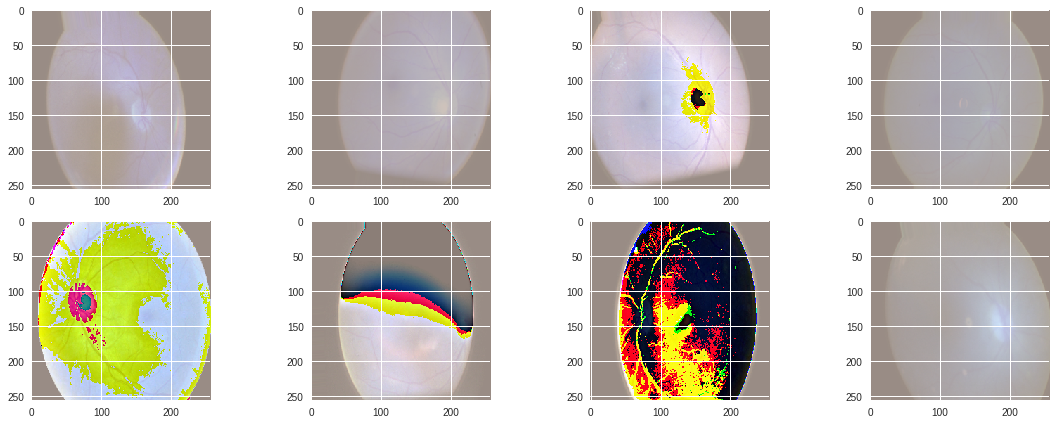

In [26]:
TRAINING_DATA_GENERATOR = ImageDataGenerator(rotation_range=ROTATION,
                                             width_shift_range=SHIFT,
                                             height_shift_range=SHIFT,
                                             brightness_range=[0.2, 1.2],
                                             channel_shift_range=CHANNEL_SHIFT,
                                             zoom_range=0.1,
                                             horizontal_flip=HORIZONTAL_FLIP,
                                             vertical_flip=VERTICAL_FLIP,
                                             shear_range=SHEAR,
                                             preprocessing_function=preprocessing_function)

# print("[INFO] Creating training data generator")
TRAINING_DATA = TRAINING_DATA_GENERATOR.flow_from_dataframe(dataframe=TRAIN, **DATAFRAME_ARGS)

# TRAINING_DATA_GENERATOR.fit(SAMPLE_DATA)

columns=4
rows=2

fig=plt.figure(figsize=(4*columns, 3*rows))

for X, y in TRAINING_DATA:
    for i in range(columns*rows):
        fig.add_subplot(rows, columns, i+1)
        img = X[i].astype(np.uint8)
        plt.imshow(img)        
    plt.tight_layout()
    break

In [27]:
###################################################################################################
#  Create data generator to augment images for training and validation
###################################################################################################

VALIDATION_DATA_GENERATOR = ImageDataGenerator(preprocessing_function=preprocessing_function)

TEST_DATA_GENERATOR = ImageDataGenerator(preprocessing_function=preprocessing_function)


In [28]:
print("[INFO] Creating validation data generator")
VALIDATION_DATA = VALIDATION_DATA_GENERATOR.flow_from_dataframe(dataframe=VALIDATION, **DATAFRAME_ARGS)

print("[INFO] Creating test data generator")
TEST_DATA = TEST_DATA_GENERATOR.flow_from_dataframe(dataframe=TEST,
                                                    **DATAFRAME_ARGS,
                                                    shuffle=False)

[INFO] Creating validation data generator
Found 4431 validated image filenames belonging to 5 classes.
[INFO] Creating test data generator
Found 4923 validated image filenames belonging to 5 classes.


In [29]:
NUM_OF_TRAINING_SAMPLES = 64 if DEBUG_MODE else len(TRAIN)
NUM_OF_VALIDATION_SAMPLES = 64 if DEBUG_MODE else len(VALIDATION)
NUM_OF_TEST_SAMPLES = 64 if DEBUG_MODE else len(TEST)
NUM_OF_TEST_STEPS = len(TEST)//BATCH_SIZE+1
CLASSES = 5
print(NUM_OF_TRAINING_SAMPLES, NUM_OF_VALIDATION_SAMPLES, NUM_OF_TEST_SAMPLES, NUM_OF_TEST_STEPS, CLASSES)

39876 4431 4923 154 5


In [30]:
###################################################################################################
# Cohen Kappa metrics
###################################################################################################


def cohen_kappa(y_true, y_pred):
    y_true_classes = tf.argmax(y_true, 1)
    y_pred_classes = tf.argmax(y_pred, 1)
    return tf.contrib.metrics.cohen_kappa(y_true_classes, y_pred_classes, CLASSES)[1]

#### Custom tune learning rate based on previous trainings

In [31]:
def step_decay(epoch):
    """Generate step decay callback function

    Arguments:
        epoch {int} -- Current epoch value

    Returns:
        float -- Updated learning rate alpha after decay
    """
    if epoch <= 20:
        LEARNING_RATE = 0.0001
        DROP_FACTOR = 0.25
        DROP_EVERY = 20
        EPOCH_OFFSET = 0
    
    if 20 < epoch <= 36:
        LEARNING_RATE = 0.001 
        DROP_FACTOR = 0.25 
        DROP_EVERY = 12
        EPOCH_OFFSET = 20
    
    if 36 < epoch <= 40:
        LEARNING_RATE = 0.0005
        DROP_FACTOR = 0.25 
        DROP_EVERY = 12  
        EPOCH_OFFSET = 36
        
    alpha = LEARNING_RATE * (DROP_FACTOR ** np.floor((1 + epoch - EPOCH_OFFSET) / DROP_EVERY))
    return float(alpha)

In [32]:
###################################################################################################
# Define callbacks
###################################################################################################

# Learning rate decay in steps
DECAY = LearningRateScheduler(step_decay)

# Checkpoint model callback
WEIGHT_NAME = os.path.join(WEIGHTS_FOLDER, "./weights.{epoch:02d}-{val_cohen_kappa:.2f}.hdf5")
CHECKPOINT = ModelCheckpoint(WEIGHT_NAME, monitor="val_cohen_kappa", mode="max",
                             save_best_only=True, save_weights_only=True, verbose=1)

EARLY_STOP = EarlyStopping(monitor='val_cohen_kappa',
                           min_delta=0.001,
                           patience=8,
                           mode='max',
                           verbose=1)

TENSORBOARD = TensorBoard(log_dir=LOGS_FOLDER,
                          histogram_freq=0,
                          # write_batch_performance=True,
                          write_graph=False,
                          write_images=True)

REDUCE_LR_ON_PLATEAU = ReduceLROnPlateau(monitor="val_loss",
                                         mode="min",
                                         factor=0.8,
                                         min_lr=1e-5,
                                         patience=4,
                                         verbose=1)

CSV_LOGGER = CSVLogger(filename=TRAINING_LOGS_FILE,
                       separator=",",
                       append=True)

CALLBACKS = [EARLY_STOP, CHECKPOINT, TENSORBOARD, REDUCE_LR_ON_PLATEAU, CSV_LOGGER, DECAY]

In [33]:
BASE_MODEL = VGG19(include_top=False, input_shape=(HEIGHT, WIDTH, DEPTH))
MODEL = Sequential()
MODEL.add(BASE_MODEL)
MODEL.add(GlobalAveragePooling2D())
MODEL.add(Dense(1024, activation='relu'))
MODEL.add(Dropout(0.5, name="LastDropout"))
MODEL.add(Dense(512, activation='relu'))
MODEL.add(Dense(CLASSES, activation='softmax'))

80142336/80134624 [==============================] - 1s 0us/step


In [34]:
if WEIGHTS_PATH:
    if os.path.exists(WEIGHTS_PATH):
        print("Load models...")
        MODEL.load_weights(WEIGHTS_PATH)

In [35]:
MODEL.count_params(), MODEL.output_shape

(21077061, (None, 5))

In [36]:
# ##################################################################################################
# # Compile model for training
# ##################################################################################################
# OPTIMISER = SGD(lr=LEARNING_RATE, decay=0.9, momentum=MOMENTUM, nesterov=True)

# if OPTIMISER_NAME  == "Adam":
#     print("[INFO]: Using Adam Optimizer")
#     OPTIMISER = Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-2, decay=0.9)

# MODEL.compile(loss=LOSS, optimizer=OPTIMISER, metrics=[*METRICS, cohen_kappa])

# K.get_session().run(tf.local_variables_initializer())

# # ##################################################################################################
# # Find optimal learning rate using another LR Finder
# # ##################################################################################################

# lr_finder = LRFinder(MODEL)
# lr_finder.find_generator(generator=TRAINING_DATA, start_lr=0.00001, end_lr=1, steps_per_epoch=NUM_OF_TRAINING_SAMPLES//BATCH_SIZE, epochs=2)

In [37]:
# lr_finder.plot_loss()

In [38]:
# ##################################################################################################
# Compile model for training
# ##################################################################################################

OPTIMISER = SGD(lr=0.0001, momentum=MOMENTUM)

MODEL.compile(loss=LOSS, optimizer=OPTIMISER, metrics=[*METRICS, cohen_kappa])

K.get_session().run(tf.local_variables_initializer())

In [39]:
%load_ext tensorboard.notebook
%tensorboard --logdir logs

# Resume training from version 4 commit

In [40]:
MODEL_FILE_PATH = get_file("vgg_train", "https://www.kaggleusercontent.com/kf/17998820/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..o947ui5zs-0hJoHcnL1IzA.T2jgMiBd7G9ZNUDr5vS225AGNloM10Z4XnY8sCrTeKtnUdfaYNjm8WKlNelZ8i4i9WEAxvX62GM1cVdPAvRU_Dgs9WfJfbrLxWeTeFYi_z_8ZsTWQ8c0yvxEaVCux0sAgYAfZee7ZF7ETp5_72vCQQ.-xrPgnpY5wlC-_M-T0z47g/trained_model.hdf5")

168697856/168696480 [==============================] - 1s 0us/step


In [41]:
MODEL = load_model(MODEL_FILE_PATH, custom_objects={"cohen_kappa": cohen_kappa})

In [42]:
# ##################################################################################################
# Compile model for training
# ##################################################################################################

OPTIMISER = SGD(lr=0.0001, momentum=MOMENTUM)

MODEL.compile(loss=LOSS, optimizer=OPTIMISER, metrics=[*METRICS, cohen_kappa])

K.get_session().run(tf.local_variables_initializer())

In [43]:
### Copy reports file to resume training results

training_logs = "https://www.kaggleusercontent.com/kf/17998820/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..yYJsSagY4m-6eFWXN8tCUQ.sPr3uaETyNibD7OB1TJ_1tavLY-Q4n66U2Sj3-zIcCrNDMCInW_qDImQVs_VLkOyPC7JkGugX-QY7VM3B7s1Bk0TYJ6dgC2jzAFfs5VDZw-4ikKuVtf63I7xWBcHv7y1tTKxuW2LUUnFy5Y0qpzIpQ.XrkiMb7sZwcIYNjm3ydX6Q/reports/training_logs.csv"
tensorflow_logs = "https://www.kaggleusercontent.com/kf/17998820/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..iuCa6xspTAu8_E7Oox7pBQ.46AQakIazKG4zMEFESnHx8PVsLlPG8kHjSiRzxz2DVqKiPjQCzWhESP7jLUS1hiXTTtqOBC_ns4GsHqiEwm0q_apwGRQHAx3UMb5VVEhHiV0lgngjl0DJaiXxHzhbIaQ3Tt7nKDXuHZOxdw0MccT_Q.yl_qRKFgrZoVUtpwSTC_cQ/logs/events.out.tfevents.1564452829.09287601ba7f"

os.system(f"curl -o ./reports/training_logs.csv {training_logs} ")
os.system(f"curl -o ./logs/events.out.tfevents.1564452829.09287601ba7f {tensorflow_logs} ")

0

In [44]:
###################################################################################################
# Train the model
###################################################################################################

print("[INFO] Training the model....")
HISTORY = MODEL.fit_generator(generator=TRAINING_DATA,
                              steps_per_epoch=NUM_OF_TRAINING_SAMPLES//BATCH_SIZE,
                              epochs=8,
                              validation_data = VALIDATION_DATA, 
                              validation_steps=NUM_OF_VALIDATION_SAMPLES//BATCH_SIZE,
                              callbacks=CALLBACKS,
                              initial_epoch=3,
                              verbose=VERBOSITY)

[INFO] Training the model....
Epoch 4/8
1246/1246 [==============================] - 6051s 5s/step - loss: 0.7171 - acc: 0.6741 - cohen_kappa: 0.5819 - val_loss: 0.5707 - val_acc: 0.7545 - val_cohen_kappa: 0.5977

Epoch 00004: val_cohen_kappa improved from -inf to 0.59767, saving model to ./weights/./weights.04-0.60.hdf5
Epoch 5/8
1246/1246 [==============================] - 5969s 5s/step - loss: 0.6311 - acc: 0.7183 - cohen_kappa: 0.6134 - val_loss: 0.5065 - val_acc: 0.7895 - val_cohen_kappa: 0.6270

Epoch 00005: val_cohen_kappa improved from 0.59767 to 0.62699, saving model to ./weights/./weights.05-0.63.hdf5
Epoch 6/8
1246/1246 [==============================] - 5970s 5s/step - loss: 0.5562 - acc: 0.7596 - cohen_kappa: 0.6407 - val_loss: 0.4566 - val_acc: 0.8088 - val_cohen_kappa: 0.6532

Epoch 00006: val_cohen_kappa improved from 0.62699 to 0.65322, saving model to ./weights/./weights.06-0.65.hdf5
Epoch 7/8
1246/1246 [==============================] - 6028s 5s/step - loss: 0.4852 -

In [45]:
print("[INFO] Storing trained model....")
MODEL.save("./trained_model.hdf5")
MODEL.save_weights("./trained_weights.hdf5")

[INFO] Storing trained model....


In [46]:
###################################################################################################
# Evaluate the model and store the report and history log
###################################################################################################

print("[INFO] Evaluating the model....")
TEST_PREDICTIONS = MODEL.predict_generator(generator=TEST_DATA,
                                           steps=NUM_OF_TEST_STEPS,
                                           verbose=VERBOSITY)
TEST_Y_PREDICTIONS = np.argmax(TEST_PREDICTIONS, axis=1)

LABELS = [0, 1, 2, 3, 4]

CLASSIFICATION_REPORT = classification_report(
    y_true=TEST_DATA.classes, y_pred=TEST_Y_PREDICTIONS, labels=LABELS)
print(CLASSIFICATION_REPORT)
with open(CLASSIFICATION_REPORT_FILE, "w") as report:
    print(CLASSIFICATION_REPORT, file=report)


CONFUSION_MATRIX = confusion_matrix(
    y_true=TEST_DATA.classes, y_pred=TEST_Y_PREDICTIONS, labels=LABELS)
print(CONFUSION_MATRIX)
with open(CONFUSION_MATRIX_FILE, "w") as report:
    print(CONFUSION_MATRIX, file=report)


COHEN_KAPPA_SCORE = cohen_kappa_score(
    y1=TEST_DATA.classes, y2=TEST_Y_PREDICTIONS, labels=LABELS)
print(COHEN_KAPPA_SCORE)
with open(COHEN_KAPPA_SCORE_FILE, "w") as report:
    print(COHEN_KAPPA_SCORE, file=report)

[INFO] Evaluating the model....
154/154 [==============================] - 581s 4s/step
              precision    recall  f1-score   support

           0       0.77      0.54      0.64       985
           1       0.73      0.96      0.83       985
           2       0.83      0.79      0.81       984
           3       0.98      1.00      0.99       984
           4       0.99      1.00      0.99       985

    accuracy                           0.86      4923
   macro avg       0.86      0.86      0.85      4923
weighted avg       0.86      0.86      0.85      4923

[[534 299 148   1   3]
 [ 27 947   9   0   2]
 [134  49 777  16   8]
 [  0   0   4 980   0]
 [  0   0   0   0 985]]
0.8222625343440866


In [47]:
# ACCURACY = HISTORY.history["acc"][-1] * 100
# VALIDATION_ACCURACY = HISTORY.history["val_acc"][-1] * 100
# LOSS = HISTORY.history["loss"][-1]
# COHEN_KAPPA = HISTORY.history["cohen_kappa"][-1]
# VALIDATION_LOSS = HISTORY.history["val_loss"][-1]
# VALIDATION_COHEN_KAPPA = HISTORY.history["val_cohen_kappa"][-1]

In [48]:
# REPORT = [
#     80*"#",
#     "\n",
#     "REPORT".center(80),
#     f'Training with {NAME} config'.center(80),
#     "\n",
#     80*"#",
#     "\n",
#     "DETAILS",
#     "\n",
#     f'Accuracy: {ACCURACY:.2f}',
#     f'Validation accuracy: {VALIDATION_ACCURACY:.2f}',
#     f'Loss: {LOSS:.4f}',
#     f'Validation Loss: {VALIDATION_LOSS:.4f}',
#     f'Cohen Kappa: {COHEN_KAPPA:.4f}',
#     f'Validation Cohen Kappa: {VALIDATION_COHEN_KAPPA:.4f}',
#     "\n",
#     80*"#",
# ]

# for line in REPORT:
#     print(line)

# FILENAME = f'REPORT.txt'

# print("[INFO] Storing the evaluation results....")
# with open(FILENAME, "w") as eval_result:
#     eval_result.write("\n".join(REPORT))

In [49]:
TESTSET_ARRAY = [[filename, "0"]
                 for filename in os.listdir(TESTSET_FOLDER)]
TESTSET = pd.DataFrame(TESTSET_ARRAY, columns=["Id", "Expected"])
TESTSET = TESTSET[:int(BATCH_SIZE*1.5)] if DEBUG_MODE else TESTSET

NUM_OF_TESTSET_SAMPLES = len(TESTSET)//BATCH_SIZE+1

TESTSET_DATA_GENERATOR = ImageDataGenerator(preprocessing_function=preprocessing_function)

print("[INFO] Creating testset data generator")
TESTSET_DATA = TESTSET_DATA_GENERATOR.flow_from_dataframe(dataframe=TESTSET,
                                                          directory=TESTSET_FOLDER,
                                                          x_col="Id",
                                                          y_col="Expected",
                                                          class_mode="categorical",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=False)

print("[INFO] Creating submission file....")
PREDICTIONS = MODEL.predict_generator(generator=TESTSET_DATA,
                                      steps=NUM_OF_TESTSET_SAMPLES,
                                      verbose=VERBOSITY)
Y_PREDICTIONS = np.argmax(PREDICTIONS, axis=1)

TESTSET["Expected"] = Y_PREDICTIONS
TESTSET.to_csv("Submission.csv", index=False)

[INFO] Creating testset data generator
Found 999 validated image filenames belonging to 1 classes.
[INFO] Creating submission file....
32/32 [==============================] - 78s 2s/step
